## What is this?

This is a very simple prototype of a new openstack client running on Jupyter. The return values are in dataframe of pandas so that you can visualize them easily.

I want to demonstrate that Jupyter can be a new server operation platform which provides the underlying power of data management and visualization tools. 

## Preparation

Create a config file for shade.

In [1]:
%%bash
mkdir -p $HOME/.config/openstack/
cat <<EOF >$HOME/.config/openstack/clouds.yml
clouds:
    myopenstack:
        auth:
            auth_url: http://192.168.1.9:5000/
            username: demo_user
            password: passw0rd
            project_name: demo
        region_name: RegionOne
EOF

Import some modules and get a connection to the openstack controller.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
from pandas.io.json import json_normalize
from shade import *
conn = openstack_cloud(cloud='myopenstack')

## Tabular output example

Define functions to retrieve list of images and instances as a simple example.

In [3]:
def list_images(columns=None):
    images = conn.list_images()
    df = DataFrame(images)
    if columns == None:
        return df
    else:
        index = [key for key in columns if key in df.keys()]
        return df[index]

In [4]:
def list_servers(columns=None):
    instances = conn.list_servers()
    instances_normalized = []
    for instance in instances:
        if 'security_groups' in instance:
            instance['security_groups'] = [sg['name'] for sg in instance['security_groups']]
        instances_normalized.append(instance)
    df = json_normalize(instances_normalized)
    df = df.rename(columns =
                   {'OS-EXT-STS:vm_state':'vm_state',
                    'OS-EXT-STS:power_state':'power_state'})
    if columns == None:
        return df
    else:
        columns_normalized = []
        for key in columns:
            if key == 'networks':
                for real_key in df.keys():
                    if real_key.startswith('networks'):
                        columns_normalized.append(real_key)
                continue
            columns_normalized.append(key)
        index = [key for key in columns_normalized if key in df.keys()]
        return df[index]

Call the functions. The results are automatically visualized since they are in pandas dataframe.

In [5]:
list_images(['id','name','status','visibility'])

,id,name,status,visibility
0,2a11be12-ea17-41e2-994c-7ebaa296e520,Docker01,active,private
1,7a13d254-d20f-4e44-9353-3f675c960828,cirros,active,private
2,c9c5790c-361c-4c03-acb9-1bf14a0e9b3d,Docker01-bak,active,private
3,6cd5ada9-3c41-4d66-9edd-9d0df8093b80,CentOS7,active,public


In [6]:
list_servers(['name','vm_state','power_state','security_groups', 'networks'])

,name,vm_state,power_state,security_groups,networks.private01
0,largeVM,error,0,NaN,NaN
1,eplite,active,1,[eplite],"[192.168.101.41, 192.168.1.101]"
2,epmysql,active,1,[eplite],"[192.168.101.40, 192.168.1.105]"
3,step-server,active,1,"[default, web-server]","[192.168.101.7, 192.168.1.102]"


## Graph output example

Define a function to retrieve instance sizes.

In [7]:
def show_vmsizes():
    instances = conn.list_servers()
    df = DataFrame()
    for instance in instances:
        flavor_id = instance['flavor']['id']
        flavor = conn.get_flavor(flavor_id)
        df = df.append(Series({
                 "name": instance['name'],
                 "vcpus": flavor['vcpus'],
                 "ram": flavor['ram'],
                 "disk": flavor['disk']
                }), ignore_index=True)
    df = df.set_index('name')
    return df

Calls the function and store the result in a variable. Again, the result is in pandas dataframe.

In [8]:
df = show_vmsizes()
df

,disk,ram,vcpus
name,,,
largeVM,40.0,4096.0,2.0
eplite,20.0,2048.0,1.0
epmysql,20.0,2048.0,1.0
step-server,20.0,1024.0,1.0


Using matplotlib, you can easily visualize the result.

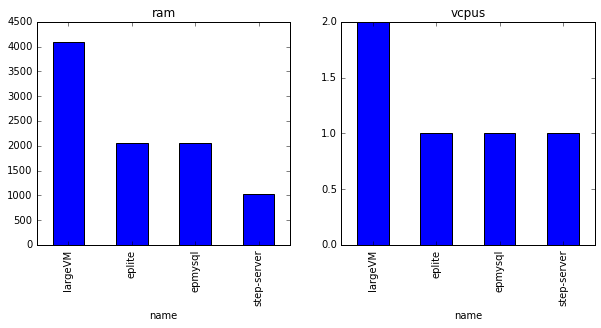

In [9]:
fig = plt.figure(figsize=(10,4))
subplot1 = fig.add_subplot(1,2,1)
subplot2 = fig.add_subplot(1,2,2)
df['ram'].plot(kind='bar',title='ram', ax=subplot1)
df['vcpus'].plot(kind='bar', title='vcpus', ax=subplot2)